# Challenge 2: Sentiment Analysis

In this challenge we will learn sentiment analysis and practice performing sentiment analysis on Twitter tweets. 

## Introduction

Sentiment analysis is to *systematically identify, extract, quantify, and study affective states and subjective information* based on texts ([reference](https://en.wikipedia.org/wiki/Sentiment_analysis)). In simple words, it's to understand whether a person is happy or unhappy in producing the piece of text. Why we (or rather, companies) care about sentiment in texts? It's because by understanding the sentiments in texts, we will be able to know if our customers are happy or unhappy about our products and services. If they are unhappy, the subsequent action is to figure out what have caused the unhappiness and make improvements.

Basic sentiment analysis only understands the *positive* or *negative* (sometimes *neutral* too) polarities of the sentiment. More advanced sentiment analysis will also consider dimensions such as agreement, subjectivity, confidence, irony, and so on. In this challenge we will conduct the basic positive vs negative sentiment analysis based on real Twitter tweets.

NLTK comes with a [sentiment analysis package](https://www.nltk.org/api/nltk.sentiment.html). This package is great for dummies to perform sentiment analysis because it requires only the textual data to make predictions. For example:

```python
>>> from nltk.sentiment.vader import SentimentIntensityAnalyzer
>>> txt = "Ironhack is a Global Tech School ranked num 2 worldwide.   Our mission is to help people transform their careers and join a thriving community of tech professionals that love what they do."
>>> analyzer = SentimentIntensityAnalyzer()
>>> analyzer.polarity_scores(txt)
{'neg': 0.0, 'neu': 0.741, 'pos': 0.259, 'compound': 0.8442}
```

In this challenge, however, you will not use NLTK's sentiment analysis package because in your Machine Learning training in the past 2 weeks you have learned how to make predictions more accurate than that. The [tweets data](https://www.kaggle.com/kazanova/sentiment140) we will be using today are already coded for the positive/negative sentiment. You will be able to use another classifier you learned in the lesson to predict the sentiment of tweets based on the labels.

## Conducting Sentiment Analysis

### Loading and Exploring Data

The dataset we'll be using today is located in the lab directory named `Sentiment140.csv.zip`. You need to unzip it into a `.csv` file. Then in the cell below, load and explore the data.

*Notes:* 

* The dataset was downloaded from [Kaggle](https://www.kaggle.com/kazanova/sentiment140). We made a slight change on the original data so that each column has a label.

* The dataset is huuuuge (1.6m tweets). When you develop your data analysis codes, you can sample a subset of the data (e.g. 20k records) so that you will save a lot of time when you test your codes.

In [122]:
import pandas as pd
import numpy as np
import nltk

In [82]:
# your code here

df = pd.read_csv("Sentiment140.csv", encoding="ISO-8859-1")
df_sample = df.sample(n=20000)

In [83]:
df_sample.head() # target: 0=negative, 4=positive

,target,id,date,flag,user,text
962109,4,1827330590,Sun May 17 10:29:06 PDT 2009,NO_QUERY,kennydude,has watched Coraline... TODAY WAS REALLY COOL
1144287,4,1977593956,Sat May 30 21:17:18 PDT 2009,NO_QUERY,vgmodugno,Full and happy from sushi mmmm nom nom
468352,0,2175974316,Mon Jun 15 02:32:45 PDT 2009,NO_QUERY,Chaaarliiieee,@CaptainCooll nope.
389720,0,2054513431,Sat Jun 06 07:31:03 PDT 2009,NO_QUERY,pinkydiamonds,OMG d dance is like super fast n it makes my h...
322089,0,2004062138,Tue Jun 02 07:36:15 PDT 2009,NO_QUERY,LaceyBourke,Stranded outside allis house


In [84]:
df_sample.target.value_counts()

0    10087
4     9913
Name: target, dtype: int64

In [85]:
df_sample.isna().sum()

target    0
id        0
date      0
flag      0
user      0
text      0
dtype: int64

### Prepare Textual Data for Sentiment Analysis

Now, apply the functions you have written in Challenge 1 to your whole data set. These functions include:

* `clean_up()`

* `tokenize()`

* `stem_and_lemmatize()`

* `remove_stopwords()`

Create a new column called `text_processed` in the dataframe to contain the processed data. At the end, your `text_processed` column should contain text instances that are cleaned up.

In [86]:
"""
Following the golden rule of coding DRY (Don't Repeat Yourself), let's import our defined functions from the 
previous challenge. For that, we can use the import_ipynb package.
"""

import import_ipynb # conda install -n kittycat import_ipynb OR pip install import_ipynb

# import your functions. Use the same name you defined in challenge-1 file. Be careful, the name of the file
# and functions can't contain "-". Use "_" instead.
from challenge_1_solutions import ( 
    clean_up, 
    tokenize, 
    stem_and_lemmatize, 
    remove_stopwords,
)

In [87]:
# your code here

def prepare_text(text):
    text = clean_up(text)
    text = tokenize(text)
    text = stem_and_lemmatize(text)
    text = remove_stopwords(text)
    return text

In [88]:
df_sample['text_processed'] = df_sample['text'].apply(prepare_text)

In [89]:
df_sample.head()

,target,id,date,flag,user,text,text_processed
962109,4,1827330590,Sun May 17 10:29:06 PDT 2009,NO_QUERY,kennydude,has watched Coraline... TODAY WAS REALLY COOL,"[ha, watch, coralin, today, wa, realli, cool]"
1144287,4,1977593956,Sat May 30 21:17:18 PDT 2009,NO_QUERY,vgmodugno,Full and happy from sushi mmmm nom nom,"[full, happi, sushi, mmmm, nom, nom]"
468352,0,2175974316,Mon Jun 15 02:32:45 PDT 2009,NO_QUERY,Chaaarliiieee,@CaptainCooll nope.,"[captaincool, nope]"
389720,0,2054513431,Sat Jun 06 07:31:03 PDT 2009,NO_QUERY,pinkydiamonds,OMG d dance is like super fast n it makes my h...,"[omg, danc, like, super, fast, n, make, head, ..."
322089,0,2004062138,Tue Jun 02 07:36:15 PDT 2009,NO_QUERY,LaceyBourke,Stranded outside allis house,"[strand, outsid, alli, hous]"


### Vectorizing Text

The purpose of this step is to create a [bag of words](https://en.wikipedia.org/wiki/Bag-of-words_model) from the processed data. The bag of words contains all the unique words in your whole text body (a.k.a. *corpus*) with the number of occurrence of each word. It will allow you to understand which words are the most important features across the whole corpus.

Also, you can imagine you will have a massive set of words. The less important words (i.e. those of very low number of occurrence) do not contribute much to the sentiment. Therefore, you only need to use the most important words to build your feature set in the next step. In our case, we will use the top 5,000 words with the highest frequency to build the features.

In the cell below, combine all the words in `text_processed` and calculate the frequency distribution of all words. A convenient library to calculate the term frequency distribution is NLTK's `FreqDist` class ([documentation](https://www.nltk.org/api/nltk.html#module-nltk.probability)). Then select the top 5,000 words from the frequency distribution.

In [90]:
# your code here

bag_words = []

for index, value in df_sample['text_processed'].iteritems():
    if value not in bag_words: # remove repeated words
        bag_words += value

top_features = [x[0] for x in nltk.FreqDist(bag_words).most_common(5000)]

In [91]:
bag_words

['ha',
 'watch',
 'coralin',
 'today',
 'wa',
 'realli',
 'cool',
 'full',
 'happi',
 'sushi',
 'mmmm',
 'nom',
 'nom',
 'captaincool',
 'nope',
 'omg',
 'danc',
 'like',
 'super',
 'fast',
 'n',
 'make',
 'head',
 'spin',
 'n',
 'forgot',
 'step',
 'strand',
 'outsid',
 'alli',
 'hous',
 'brazil',
 'tommorow',
 'way',
 'hbc',
 'im',
 'late',
 'beezan',
 'choic',
 'assur',
 'fix',
 'idea',
 'happen',
 'write',
 'vocal',
 'look',
 'vocalist',
 'know',
 'anyon',
 'coronadorealtor',
 'hey',
 'hey',
 'go',
 'ha',
 'gym',
 'day',
 'hope',
 'enjoy',
 'last',
 'friday',
 'twenti',
 'kayle',
 'yawn',
 'pretti',
 'good',
 'thank',
 'awww',
 'sorri',
 'hear',
 'feel',
 'better',
 'soon',
 'lt',
 'want',
 'babi',
 'back',
 'nessi',
 'yes',
 'open',
 'eleven',
 'hun',
 'thank',
 'god',
 'hehe',
 'xxx',
 'twit',
 'long',
 'time',
 'im',
 'go',
 'sleep',
 'alreadi',
 'even',
 'philippin',
 'im',
 'realli',
 'sleep',
 'late',
 'lizclaman',
 'googl',
 'face',
 'haha',
 'would',
 'luv',
 'see',
 'hey',

### Building Features

Now let's build the features. Using the top 5,000 words, create a 2-dimensional matrix to record whether each of those words is contained in each document (tweet). Then you also have an output column to indicate whether the sentiment in each tweet is positive. For example, assuming your bag of words has 5 items (`['one', 'two', 'three', 'four', 'five']`) out of 4 documents (`['A', 'B', 'C', 'D']`), your feature set is essentially:

| Doc | one | two | three | four | five | is_positive |
|---|---|---|---|---|---|---|
| A | 1 | 0 | 0 | 1 | 0 | 1 |
| B | 0 | 0 | 0 | 1 | 1 | 0 |
| C | 0 | 1 | 0 | 0 | 0 | 1 |
| D | 1 | 0 | 0 | 0 | 1 | 0|



[![Building Features](building-features.jpg)](https://www.youtube.com/watch?v=-vVskDsHcVc)

In [92]:
# your code here

def build_features(words):
    features = {}
    for w in top_features:
        features[w] = (w in words)
    return features

featuresets = []

for index, row in df_sample.iterrows():
    featuresets.append((build_features(row['text_processed']), row['target']==4))

In [93]:
featuresets[0]

({'go': False,
  'get': False,
  'day': False,
  'wa': True,
  'good': False,
  'work': False,
  'like': False,
  'love': False,
  'quot': False,
  'u': False,
  'today': True,
  'got': False,
  'time': False,
  'lol': False,
  'miss': False,
  'want': False,
  'back': False,
  'thank': False,
  'one': False,
  'feel': False,
  'know': False,
  'amp': False,
  'see': False,
  'think': False,
  'realli': True,
  'im': False,
  'night': False,
  'need': False,
  'hope': False,
  'watch': True,
  'well': False,
  'oh': False,
  'new': False,
  'na': False,
  'make': False,
  'come': False,
  'still': False,
  'ha': True,
  'home': False,
  'last': False,
  'morn': False,
  'much': False,
  'look': False,
  'twitter': False,
  'great': False,
  'tomorrow': False,
  'sad': False,
  'sleep': False,
  'haha': False,
  'wait': False,
  'wish': False,
  'bad': False,
  'right': False,
  'veri': False,
  'whi': False,
  'fun': False,
  'friend': False,
  'follow': False,
  'week': False,
  'tri'

In [94]:
featuresets[1]

({'go': False,
  'get': False,
  'day': False,
  'wa': False,
  'good': False,
  'work': False,
  'like': False,
  'love': False,
  'quot': False,
  'u': False,
  'today': False,
  'got': False,
  'time': False,
  'lol': False,
  'miss': False,
  'want': False,
  'back': False,
  'thank': False,
  'one': False,
  'feel': False,
  'know': False,
  'amp': False,
  'see': False,
  'think': False,
  'realli': False,
  'im': False,
  'night': False,
  'need': False,
  'hope': False,
  'watch': False,
  'well': False,
  'oh': False,
  'new': False,
  'na': False,
  'make': False,
  'come': False,
  'still': False,
  'ha': False,
  'home': False,
  'last': False,
  'morn': False,
  'much': False,
  'look': False,
  'twitter': False,
  'great': False,
  'tomorrow': False,
  'sad': False,
  'sleep': False,
  'haha': False,
  'wait': False,
  'wish': False,
  'bad': False,
  'right': False,
  'veri': False,
  'whi': False,
  'fun': False,
  'friend': False,
  'follow': False,
  'week': False,
  

In [95]:
"""
Each element of featuresets is a a tuple (per tweet). The first element of the tuple is a dictionary where 
keys are the words from our bag of words, and values is True/False for if the word exist or not in the tweet text.
The second element of the dictionary is True/False for the value of the target (4=True/0=False)
"""

'\nEach element of featuresets is a a tuple (per tweet). The first element of the tuple is a dictionary where \nkeys are the words from our bag of words, and values is True/False for if the word exist or not in the tweet text.\nThe second element of the dictionary is True/False for the value of the target (4=True/0=False)\n'

In [96]:
df = pd.DataFrame.from_records(featuresets)
df.head()

,0,1
0,"{'go': False, 'get': False, 'day': False, 'wa'...",True
1,"{'go': False, 'get': False, 'day': False, 'wa'...",True
2,"{'go': False, 'get': False, 'day': False, 'wa'...",False
3,"{'go': False, 'get': False, 'day': False, 'wa'...",False
4,"{'go': False, 'get': False, 'day': False, 'wa'...",False


In [98]:
type(df[1])

pandas.core.series.Series

In [101]:
df_target = pd.DataFrame(df[1])
df_target.rename(columns={1: 'is_positive'}, inplace=True)
df_target.head()

,is_positive
0,True
1,True
2,False
3,False
4,False


In [102]:
df_target.shape

(20000, 1)

In [103]:
df_target.columns

Index(['is_positive'], dtype='object')

In [104]:
df_bag_words = pd.DataFrame(df[0])

In [105]:
df_bag_words.head()

,0
0,"{'go': False, 'get': False, 'day': False, 'wa'..."
1,"{'go': False, 'get': False, 'day': False, 'wa'..."
2,"{'go': False, 'get': False, 'day': False, 'wa'..."
3,"{'go': False, 'get': False, 'day': False, 'wa'..."
4,"{'go': False, 'get': False, 'day': False, 'wa'..."


In [106]:
df_bag_words.iloc[0][0]

{'go': False,
 'get': False,
 'day': False,
 'wa': True,
 'good': False,
 'work': False,
 'like': False,
 'love': False,
 'quot': False,
 'u': False,
 'today': True,
 'got': False,
 'time': False,
 'lol': False,
 'miss': False,
 'want': False,
 'back': False,
 'thank': False,
 'one': False,
 'feel': False,
 'know': False,
 'amp': False,
 'see': False,
 'think': False,
 'realli': True,
 'im': False,
 'night': False,
 'need': False,
 'hope': False,
 'watch': True,
 'well': False,
 'oh': False,
 'new': False,
 'na': False,
 'make': False,
 'come': False,
 'still': False,
 'ha': True,
 'home': False,
 'last': False,
 'morn': False,
 'much': False,
 'look': False,
 'twitter': False,
 'great': False,
 'tomorrow': False,
 'sad': False,
 'sleep': False,
 'haha': False,
 'wait': False,
 'wish': False,
 'bad': False,
 'right': False,
 'veri': False,
 'whi': False,
 'fun': False,
 'friend': False,
 'follow': False,
 'week': False,
 'tri': False,
 'happi': False,
 'tonight': False,
 'onli': False,

In [107]:
df_features = pd.DataFrame.from_dict(dic for dic in df_bag_words[0])

In [108]:
df_features.head() # True/False is same as 1/0

,go,get,day,wa,good,work,like,love,quot,u,...,whisper,fliplloyd,eczema,auckland,lololol,vo,ganun,pala,gumbal,plannin
0,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [111]:
df_features.shape

(20000, 5000)

### Building and Training Logistic Regression Model

In this step you will split your feature set into a training and a test set. Then you will create a Logistic Regression classifier instance to train with the training dataset.


In [112]:
# your code here
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


X = df_features
y = df_target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=123)

In [116]:
logisticr = LogisticRegression().fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


### Testing the Model

Now we'll test our classifier with the test dataset. Please do this using different accuracy methods!

In [118]:
# your code here

predictions = logisticr.predict(X_test)
logisticr.score(X_test, y_test)

0.734125

In [119]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)

[[2934 1063]
 [1064 2939]]


<AxesSubplot:>

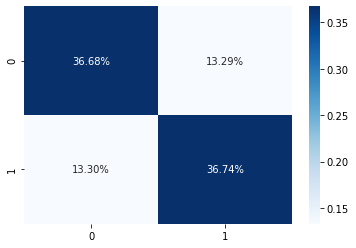

In [123]:
import seaborn as sns

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [124]:
from sklearn.metrics import precision_score, recall_score, f1_score
# is_positive = True
print(precision_score(y_test, predictions, pos_label=True))
print(recall_score(y_test, predictions, pos_label=True))
print(f1_score(y_test, predictions, pos_label=True))

0.7343828085957022
0.7341993504871347
0.7342910680824486


In [125]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, predictions)

0.7341249441952811

## Bonus Question: Improve Model Performance

If you are still not exhausted so far and want to dig deeper, try to improve your classifier performance. There are many aspects you can dig into, for example:

* Improve stemming and lemmatization. Inspect your bag of words and the most important features. Are there any words you should furuther remove from analysis? You can append these words to further remove to the stop words list.

* Remember we only used the top 5,000 features to build model? Try using different numbers of top features. The bottom line is to use as few features as you can without compromising your model performance. The fewer features you select into your model, the faster your model is trained. Then you can use a larger sample size to improve your model accuracy score.

In [ ]:
# your code here